In [13]:
# Imports
import torch
import torch.nn as nn
from sklearn.metrics import precision_score
from sklearn.preprocessing import RobustScaler
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd


In [14]:
# Custom model architecture
class CNNMetricsStatistics(nn.Module):
    def __init__(self, input_dimension, output_dimension, dropout_rate=0.15):
        super(CNNMetricsStatistics, self).__init__()

        self.input_dimension = input_dimension  # Assign input dimension

        # Residual blocks for simplification
        class ResidualBlock(nn.Module):
            def __init__(self, in_channels, out_channels, dropout_rate):
                super(ResidualBlock, self).__init__()
                self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)  # First convolutional layer
                self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)  # Second convolutional layer
                self.skip = nn.Sequential(nn.Conv1d(in_channels, out_channels, kernel_size=1))  # Third convolutional layer
                self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
                self.relu = nn.ReLU()  # ReLU activation

                # Display residual block layer dimensions
                print("Conv1", self.conv1)
                print("Conv2", self.conv2)
                print("Skip", self.skip)
                print("Dropout", self.dropout)
                print("ReLU", self.relu)

            def forward(self, x):  # Pass forward through network
                residual = self.skip(x)
                out = self.relu(self.conv1(x))
                out = self.dropout(out)
                out = self.conv2(out)
                return self.relu(out + residual)

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            ResidualBlock(16, 16, dropout_rate),
        )
        print("conv_layers", self.conv_layers)  # Display convolutional layer dimensions

        self.adaptive_pool = nn.AdaptiveAvgPool1d(4)  # Pooling layer

        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(64, 32),  # First linear layer
            nn.ReLU(),  # First ReLU activation
            nn.Dropout(dropout_rate),  # Dropout layer
            nn.Linear(32, 16),  # Second linear layer
            nn.ReLU(),  # Second ReLU activation
        )
        print("fc_layers", self.fc_layers)  # Display fully connected layer dimensions

        self.output_layer = nn.Linear(16, output_dimension)  # Linear layer

    def forward(self, x):
        x = x.unsqueeze(1)  # Pass forward through network
        x = self.conv_layers(x)
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return self.output_layer(x)


In [15]:
# Helper functions
def time_to_hour(time_str):
    """Convert time from string to integer"""
    time_parts = str(time_str).split(':')  # Convert from HH:MM to HH
    return int(time_parts[0])

def one_hot_encoding(column):
    """Perform one-hot encoding on non-numerical columns"""
    unique_values = sorted(column.unique())
    oh_encoding = np.zeros((len(column), len(unique_values)))

    # Assign values
    val_idx = {value: idx for idx, value in enumerate(unique_values)}
    for i, value in enumerate(column):
        oh_encoding[i, val_idx[value]] = 1

    return oh_encoding, unique_values


In [16]:
# Data preprocessing
def prepare_data(file_path):
    df = pd.read_csv(file_path)  # Read from .csv file

    day_one_hot, day_categories = one_hot_encoding(df['day_of_week'])  # Perform one hot encoding
    time_hour = df['time_of_day'].apply(time_to_hour).values.reshape(-1, 1)  # Convert time_of_day to hours

    feature_columns = ['splpk', 'splrms', 'dissim', 'impulsivity', 'peakcount']  # Columns used to predict time since exposure
    numerical_features = df[feature_columns].values

    # Combine all features
    x = np.hstack([numerical_features, day_one_hot, time_hour])
    y = df['time_since_exposure'].values.reshape(-1, 1)  # Other columns used to predict time since exposure

    # Use RobustScaler instead of StandardScaler - less sensitive to outliers
    scaler_x = RobustScaler(quantile_range=(10, 90))
    scaler_y = RobustScaler(quantile_range=(10, 90))

    # Scale features
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y)

    # Convert to tensors
    x_tensor = torch.FloatTensor(x_scaled)
    y_tensor = torch.FloatTensor(y_scaled)

    return x_tensor, y_tensor, scaler_y


In [17]:
# Split train/test
def train_test_split(x, y, test_size=0.2, random_seed=42):
    torch.manual_seed(random_seed)  # Set random seed for reproducibility
    n_samples = x.shape[0]  # Set number of samples
    indices = torch.randperm(n_samples)  # Set random indices
    split_idx = int(n_samples * (1 - test_size))  # Determine indices for train/test

    train_indices = indices[:split_idx]  # Training data
    test_indices = indices[split_idx:]  # Testing data

    # Training/testing subsets
    x_train, x_test = x[train_indices], x[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return x_train, x_test, y_train, y_test


In [18]:
# Training
def train_model_with_early_stopping(model, x_train, y_train, x_test, y_test, criterion, optimizer, num_epochs, patience=10):
    train_losses = []  # Training loss list
    test_losses = []  # Testing loss list

    # Small batch size
    batch_size = 16
    n_samples = x_train.shape[0]

    # Early stopping
    best_test_loss = float("inf")
    patience_counter = 0

    # Learning rate warm up to improve optimization
    warmup_epochs = 5  # Number of warmup epochs
    initial_lr = optimizer.param_groups[0]['lr']

    for epoch in range(num_epochs):  # Iterate through epochs
        model.train()  # Model will be trained
        epoch_losses = []  # List of epoch losses

        # Warm up learning rate
        if epoch < warmup_epochs:
            lr = initial_lr * ((epoch + 1) / warmup_epochs)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        # Shuffle training data
        indices = torch.randperm(n_samples)
        x_train = x_train[indices]
        y_train = y_train[indices]

        # Loop through data in batches
        for i in range(0, n_samples, batch_size):
            batch_x = x_train[i:i+batch_size]  # Inputs
            batch_y = y_train[i:i+batch_size]  # Labels

            batch_x = batch_x + torch.randn_like(batch_x) * 0.001  # Add noise to improve generalization

            optimizer.zero_grad()  # Gradient is 0
            outputs = model(batch_x)  # Model training data
            loss = criterion(outputs, batch_y)  # Calculate loss

            loss.backward()  # Back propagate
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Prevent exploding gradient
            optimizer.step()  # Update parameters

            epoch_losses.append(loss.item())  # Append current loss

        train_loss = np.mean(epoch_losses)  # Calculate training loss
        train_losses.append(train_loss)  # Append training loss

        # Test loss
        model.eval()  # Model will be evaluated
        with torch.no_grad():  # Do not calculate gradients
            test_outputs = model(x_test)  # Model test data
            test_loss = criterion(test_outputs, y_test).item()  # Calculate loss
            test_losses.append(test_loss)  # Append current loss

        # Early stopping
        if test_loss < best_test_loss:
            best_test_loss = test_loss  # Update test loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1  # Increment patience counter

        # Determine if training should end
        if patience_counter >= patience:
            print("Early stopping at epoch", epoch + 1, "Best test loss:", best_test_loss)
            break  # Stop training

        if (epoch + 1) % 10 == 0:  # Display sample results
            print("Epoch", epoch + 1, "/", num_epochs, "\tTrain Loss:", train_loss, "\tTest Loss:", test_loss)

    return train_losses, test_losses


In [19]:
# Train model
# Set model parameters
output_dimension = 1  # One target value
layer_widths = [128, 64, 32]  # Layer widths
learning_rate = 0.005  # Learning rate
num_epochs = 100  # Number of epochs to iterate through
dropout_rate = 0.1  # Dropout rate

# Prepare data
x, y, scaler_y = prepare_data('Before_During_After_Exposure_0601_0719.csv')
input_dimension = x.shape[1]  # Determine number of input features
x_train, x_test, y_train, y_test = train_test_split(x, y)  # Perform train/test split

cnn_model = CNNMetricsStatistics(input_dimension, output_dimension, dropout_rate)  # Initialize CNN model

criterion = nn.MSELoss()  # Loss function
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=learning_rate, weight_decay=0.01)  # Initialize optimizer

train_losses, test_losses = train_model_with_early_stopping(cnn_model, x_train, y_train, x_test, y_test, criterion, optimizer, num_epochs)  # Train model


Conv1 Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
Conv2 Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
Skip Sequential(
  (0): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
)
Dropout Dropout(p=0.1, inplace=False)
ReLU ReLU()
conv_layers Sequential(
  (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (1): ReLU()
  (2): ResidualBlock(
    (conv1): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (skip): Sequential(
      (0): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (relu): ReLU()
  )
)
fc_layers Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
)
Epoch 10 / 100 	Train Loss: 0.14621739893423757 	Test Loss: 0.14445267617702484
Epoch 20 / 100 	Train Loss: 0.14

In [20]:
# Confusion matrix
def confusion_matrix(y_true, y_pred, num_classes):
    conf_mat = np.zeros((num_classes, num_classes), dtype=int)  # Initialize empty matrix

    for true, pred in zip(y_true, y_pred):  # Iterate through labels
        conf_mat[true, pred] += 1  # Increment value in appropriate location

    return conf_mat

# Low threshold
threshold = 0.2
y_true = (y_test.numpy() > threshold).astype(int).flatten()  # Convert ground truth to binary
y_pred = (cnn_model(x_test).detach().numpy() > threshold).astype(int).flatten()  # Convert predicted to binary
num_classes = 2  # Binary classification
conf_mat = confusion_matrix(y_true, y_pred, num_classes)  # Create confusion matrix
print("Confusion Matrix:\n", conf_mat, "\n")  # Display confusion matrix with low threshold

# High threshold
threshold = 0.5
y_true = (y_test.numpy() > threshold).astype(int).flatten()  # Convert ground truth to binary
y_pred = (cnn_model(x_test).detach().numpy() > threshold).astype(int).flatten()  # Convert predicted to binary
conf_mat = confusion_matrix(y_true, y_pred, num_classes)  # Create confusion matrix
print("Confusion Matrix:\n", conf_mat, "\n")  # Display confusion matrix


Confusion Matrix:
 [[444 454]
 [123 370]] 

Confusion Matrix:
 [[1044    4]
 [ 331   12]] 



In [21]:
# ARIMA and ANOVA
# ARIMA analysis
def arima_analysis(predictions, order=(1, 1, 1)):
    """
    Autoregressive integrated moving average
    Predicts future values
    """
    arima_model = ARIMA(predictions, order=order)  # Initialize model
    fitted_model = arima_model.fit()  # Fit model
    forecast = fitted_model.predict(len(predictions))  # Make prediction
    return arima_model, forecast

def plot_arima_forecast(model, x_test):
    """Plot ARIMA forecast"""
    predictions = model(x_test).detach().numpy().flatten()  # Get trained model predictions

    _, forecast = arima_analysis(predictions)  # Perform ARIMA forecast on predictions

    # Display data
    plt.figure(figsize=(15, 6))
    plt.plot(predictions, label="Predictions", color="blue")

    # Plot ARIMA forecast
    plt.title("ARIMA Forecast")
    plt.xlabel("Time Steps")
    plt.ylabel("Predicted Values")
    plt.show()

predictions = cnn_model(x_test).detach().numpy().reshape(-1, 1)  # Ensure data is 1D
_, forecast = arima_analysis(predictions)  # Make prediction using ARIMA

print("Forecast:\n", forecast, "\n")  # Display forecast

# ANOVA Analysis
before_exposure = predictions[:144]  # Before first exposure
during_exposure = predictions[144:375]  # During on/off exposure
after_exposure = predictions[375:]  # After final exposure

def anova_analysis(groups):
    """
    Performs analysis of variance/displays results
    """
    num_groups = len(groups)  # Number of groups
    total_samples = sum(len(group) for group in groups)  # Number of samples
    overall_mean = np.mean(np.concatenate(groups))  # Overall mean
    ss_between = sum(len(group) * (np.mean(group) - overall_mean) ** 2 for group in groups)  # Sum of squares between groups
    ss_within = sum(np.sum((group - np.mean(group)) ** 2) for group in groups)  # Sum of squares within groups
    ss_total = ss_between + ss_within  # Sum of squares total

    # Degrees of freedom
    df_between = num_groups - 1
    df_within = total_samples - num_groups
    df_total = total_samples - 1

    # Mean square
    ms_between = ss_between / df_between
    ms_within = ss_within / df_within

    f_value = ms_between / ms_within  # F-value
    p_value = stats.f.sf(f_value, df_between, df_within)  # P-value
    f_crit = stats.f.ppf(0.95, df_between, df_within)  # F critical value

    # Create a formatted output table
    data = [
        ["Between Groups\t\t", ss_between, df_between, ms_between, f_value, p_value, f_crit],
        ["Within Groups", ss_within, df_within, ms_within, "", "", ""],  # "" removes NaN
        ["Total", ss_total, df_total, "", "", "", ""],  # "" removes NaN
    ]

    bg = data[0]  # Between groups
    wg = data[1]  # Within groups
    t = data[2]  # Total

    return bg, wg, t

between_groups, within_groups, total = anova_analysis([before_exposure, during_exposure, after_exposure])  # Perform analysis

# Display ANOVA results
print("ANOVA Analysis")
print("Source of Variation\t SS\t\t\t df\t\t\t MS\t\t\t F\t\t\t P-value\t\t F crit")
print(between_groups[0], round(between_groups[1], 4), "\t", round(between_groups[2], 4), "\t\t\t", round(between_groups[3], 4),
      "\t\t", round(between_groups[4], 4), "\t", round(between_groups[5], 4), "\t\t", round(between_groups[6], 4))
print(within_groups[0], "\t\t", round(within_groups[1], 4), "\t", round(within_groups[2], 4), "\t\t", round(within_groups[3], 4))
print(total[0], "\t\t\t\t", round(total[1], 4), "\t", round(total[2], 4), "\n")

# ANOVA trained predictions
trained_predictions = cnn_model(x_train).detach().numpy().reshape(-1, 1)
arima_model, forecast = arima_analysis(trained_predictions)
forecast_predictions = forecast

# Determine if large difference in mean is present
f_stat, p_value = stats.f_oneway(before_exposure, during_exposure, after_exposure)
print("ANOVA F:", f_stat)
print("ANOVA p-value:", p_value)


Forecast:
 [0.22800924] 

ANOVA Analysis
Source of Variation	 SS			 df			 MS			 F			 P-value		 F crit
Between Groups		 0.0127 	 2 			 0.0064 		 0.518 	 0.5958 		 3.0022
Within Groups 		 17.0151 	 1388 		 0.0123
Total 				 17.0278 	 1390 

ANOVA F: [0.51799884]
ANOVA p-value: [0.59582658]


In [22]:
# Paired t-test for exposure periods
def t_test_exposure_periods(group1, group2):
    """
    Performs t-test between during exposure and after exposure
    """

    # Ensure equal lengths of groups
    min_length = min(len(group1), len(group2))
    group1 = group1[:min_length]
    group2 = group2[:min_length]

    t_stat, p_value = stats.ttest_rel(group1, group2)  # Perform t-test between groups
    return t_stat, p_value

# Significance test: T-test
t_stat, p_value = t_test_exposure_periods(during_exposure, after_exposure)
print("T-Test Exposure Periods (During vs After Exposure):\nT-Statistic:", t_stat, "\tP-Value:", p_value)


T-Test Exposure Periods (During vs After Exposure):
T-Statistic: [-0.02375709] 	P-Value: [0.98106696]


In [23]:
# Performance evaluation
# Calculate accuracy
def calculate_accuracy(y_true, y_pred):
    """
    Determine accuracy of predictions
    """
    correct = (y_true == y_pred).mean()
    return correct / len(y_true)

# Calculate MSE
def calculate_mse(y_true, y_pred):
    """
    Determine mean square error
    """
    error = (y_true - y_pred) ** 2
    return np.mean(error)

# Calculate F1 score
def calculate_f1_score(y_true, y_pred):
    """
    Measure model performance with precision/recall
    """
    tp = ((y_true == 1) & (y_pred == 1)).sum()
    fp = ((y_true == 0) & (y_pred == 1)).sum()
    fn = ((y_true == 1) & (y_pred == 0)).sum()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

y_pred_binary = (cnn_model(x_test).detach().numpy() > threshold).astype(int).flatten()  # Predicted values
y_true_binary = y_true  # Real values

# Calculate evaluation metrics
accuracy = calculate_accuracy(y_true_binary, y_pred_binary)
mse = calculate_mse(y_test.numpy().flatten(), cnn_model(x_test).detach().numpy().flatten())
f1 = calculate_f1_score(np.array(y_true_binary), np.array(y_pred_binary))
test_precision = precision_score(y_true_binary, y_pred_binary)

# Model performance results
print("Accuracy:", accuracy)
print("MSE:", mse)
print("F1:", f1)
print("Precision:", test_precision)

# Determine significance of p_value
if p_value < 0.05:
    print("There is a statistical significance")
else:
    print("There is no statistical significance")


Accuracy: 0.0005457699982582908
MSE: 0.14241233
F1: 0.06685236768802229
Precision: 0.75
There is no statistical significance


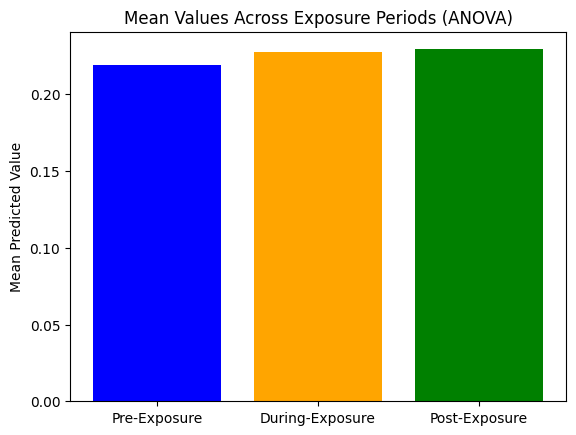

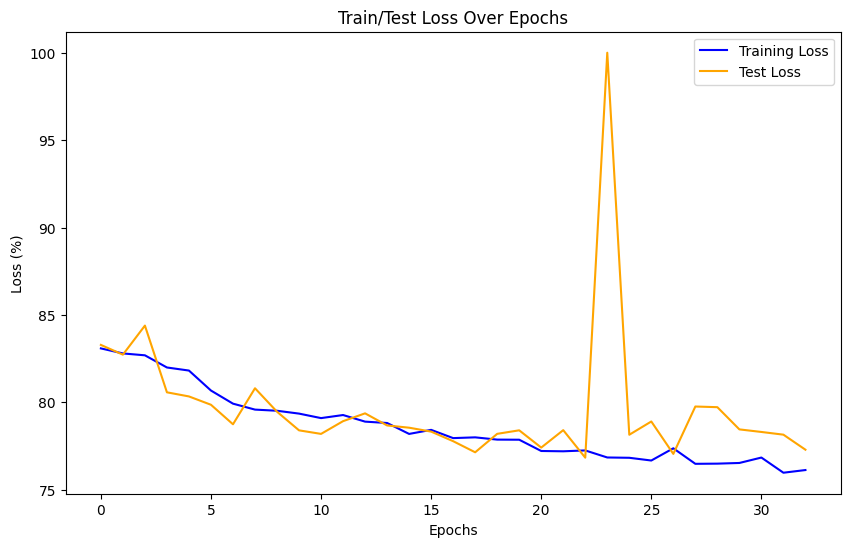

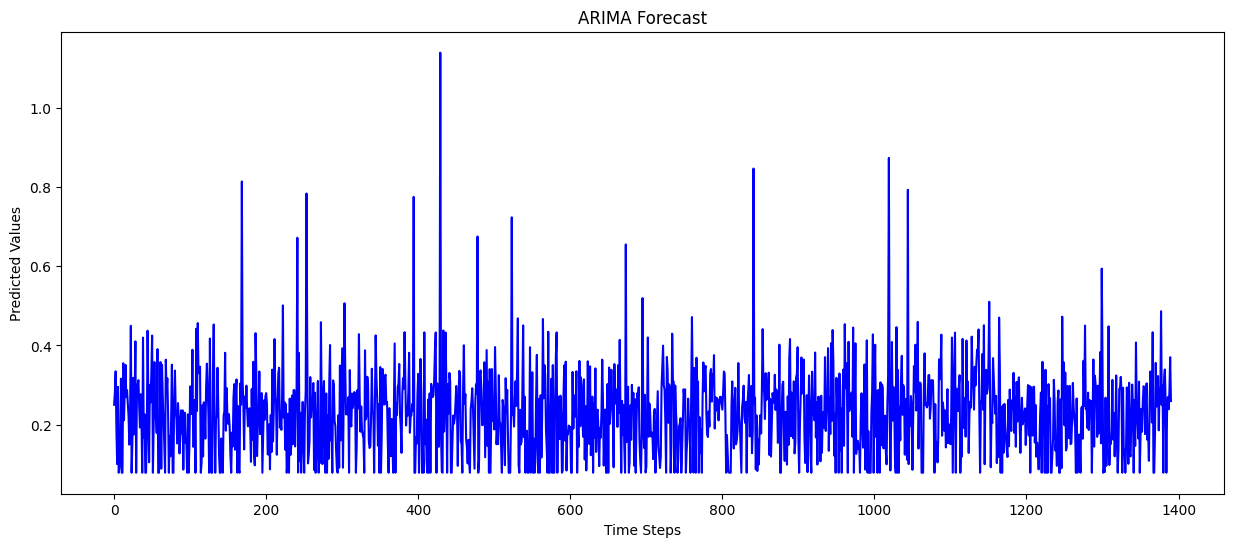

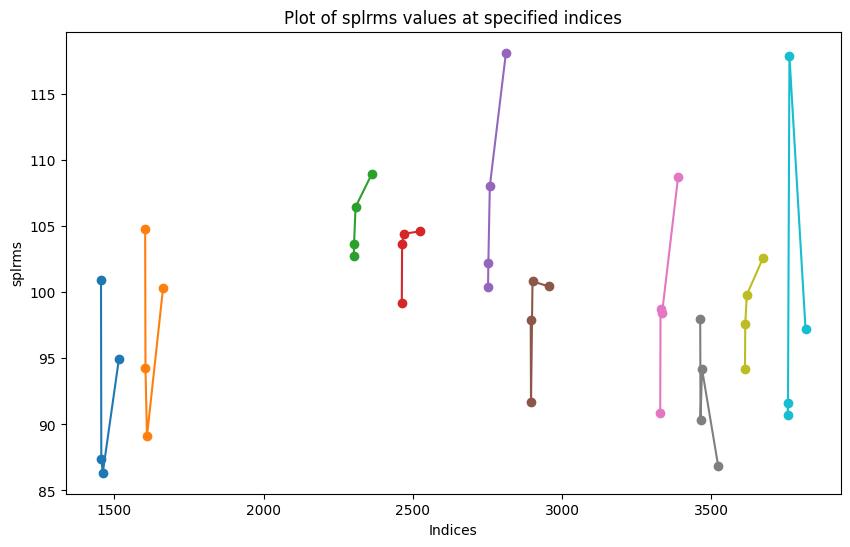

In [24]:
# Data plotting
# ANOVA bar chart
exposure_periods = ["Pre-Exposure", "During-Exposure", "Post-Exposure"]
means = [np.mean(before_exposure), np.mean(during_exposure), np.mean(after_exposure)]
plt.bar(exposure_periods, means, color=["blue", "orange", "green"])
plt.title("Mean Values Across Exposure Periods (ANOVA)")
plt.ylabel("Mean Predicted Value")
plt.show()

# Convert train/test loss to percentages
max_loss = max(max(train_losses), max(test_losses))
train_losses_percentages = [(loss / max_loss) * 100 for loss in train_losses]
test_losses_percentages = [(loss / max_loss) * 100 for loss in test_losses]

# Display train/test results
plt.figure(figsize=(10, 6))
plt.plot(train_losses_percentages, label="Training Loss", color="blue")
plt.plot(test_losses_percentages, label="Test Loss", color="orange")
plt.title("Train/Test Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss (%)")
plt.legend()
plt.show()

plot_arima_forecast(cnn_model, x_test)

# Read CSV file
file_path = 'Before_During_After_Exposure_0601_0719.csv'  # File containing data
df = pd.read_csv(file_path)

# splrms values to plot
indices_groups = [
    # 0, 10, 60, and 600 minutes after sonar exposure
    [1455, 1456, 1461, 1515],
    [1603, 1604, 1609, 1663],
    [2302, 2303, 2308, 2362],
    [2463, 2464, 2469, 2523],
    [2752, 2753, 2758, 2812],
    [2895, 2896, 2901, 2955],
    [3329, 3330, 3335, 3389],
    [3463, 3464, 3469, 3523],
    [3613, 3614, 3619, 3673],
    [3756, 3757, 3762, 3816]
]

plt.figure(figsize=(10, 6))

for indices in indices_groups:  # Plot each group of indices on a separate line
    splrms_values = df.loc[indices, 'splrms']
    plt.plot(indices, splrms_values, marker='o', linestyle='-', label="Indices" + str(indices))

plt.xlabel('Indices')
plt.ylabel('splrms')
plt.title('Plot of splrms values at specified indices')
plt.show()
